In [17]:
!curl https://download.mosek.com/stable/8.1.0.82/mosektoolslinux64x86.tar.bz2 --output /root/mosektoolslinux64x86.tar.bz2
!cd /root/; tar xvf /root/mosektoolslinux64x86.tar.bz2
from google.colab import drive
drive.mount('/content/gdrive')
!cp -avr /content/gdrive/My\ Drive/Mosek/mosek.lic /root/mosek/
!pip install git+https://github.com/convexengineering/gpkit
!pip show gpkit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.3M  100 40.3M    0     0  31.0M      0  0:00:01  0:00:01 --:--:-- 31.0M
mosek/8/tools/examples/python/parameters.py
mosek/8/toolbox/examples/cqo1.m
mosek/8/toolbox/r2014a/mskqpopt.m
mosek/8/tools/examples/fusion/java/breaksolver.java
mosek/8/toolbox/r2014a/mskcheck.m
mosek/8/tools/examples/fusion/cxx/lo1.cc
mosek/8/tools/examples/data/dgo.f
mosek/8/tools/examples/dotnet/scopt1.cs
mosek/8/tools/examples/dotnet/solvebasis.cs
mosek/8/toolbox/r2014aom/mskerrmsg.m
mosek/8/toolbox/examples/simple.m
mosek/8/tools/examples/java/solutionquality.java
mosek/8/tools/examples/fusion/dotnet/production.cs
mosek/8/tools/examples/fusion/java/Makefile
mosek/8/tools/examples/fusion/python/lo1.py
mosek/8/tools/examples/fusion/java/duality.java
mosek/8/tools/platform/linux64x86/bin/libcilkrts.so.5
mosek/8/toolbox/examples/qo2.m
mosek/8/tools/ex

In [32]:
import networkx as nx
import re
import matplotlib.pyplot as plt
import numpy as np
from gpkit import Variable, VectorVariable, Model
from gpkit.nomials import Monomial, Posynomial, PosynomialInequality
import pprint
from collections import defaultdict
import sys
import json
import time

#CHANGE THE FILE NAME IN ALL THE REQUIRED PLACES, FOR SAVING OUTPUT SIZING FILES AS WELL

filename = "/content/gdrive/MyDrive/ISCAS Circuits/c3540.txt"  # We can change the file with location-change
tau = 5 #ps
m = 1000
max_gate_size = 64
min_gate_size = 1
max_input_size = 50

rec_lim = 30000
sys.setrecursionlimit(rec_lim)

In [33]:
def parse_verilog(verilog_code):
    graph = nx.DiGraph()
    wires_regex = re.compile(r'wire\s+([A-Za-z0-9_,\s]+);')
    gate_regex = re.compile(r'(nand|nor|not)\s+([A-Za-z0-9_]+)\s*\(([^)]+)\)')
    inputs_regex = re.compile(r'input\s+([A-Za-z0-9_,\s]+);')
    outputs_regex = re.compile(r'output\s+([A-Za-z0-9_,\s]+);')


    input_signals = set()
    output_signals = set()
    wire_signals = set()
    gate_info = {}

    # Extract primary inputs
    input_match = inputs_regex.search(verilog_code)
    if input_match:
        input_signals = set(map(str.strip, input_match.group(1).split(',')))

    # Extract primary outputs
    output_match = outputs_regex.search(verilog_code)
    if output_match:
        output_signals = set(map(str.strip, output_match.group(1).split(',')))

    # Extract wire declarations
    wire_match = wires_regex.search(verilog_code)
    if wire_match:
        wire_signals = set(map(str.strip, wire_match.group(1).split(',')))

    for match in gate_regex.finditer(verilog_code):
        gate_type, gate_id, signal_list = match.groups()
        signal_nodes = list(map(str.strip, signal_list.split(',')))
        gate_output = signal_nodes[0]
        gate_inputs = signal_nodes[1:]

        # Store gate metadata
        gate_info[gate_output] = {'type': gate_type, 'inputs': gate_inputs, 'id': gate_id}

        # Add edges from inputs to outputs
        for signal in gate_inputs:
            graph.add_edge(signal, gate_output, gate_type=gate_type)

    # Identify unused wires and add them as isolated nodes
    all_nodes = input_signals | output_signals | set(gate_info.keys())
    unused_wires = wire_signals - all_nodes
    for wire in unused_wires:
        graph.add_node(wire)

    return graph, list(input_signals), list(output_signals), gate_info

def compute_longest_path(graph, input_nodes, output_nodes):
    longest_path = []
    max_length = 0

    for src in input_nodes:
        for dst in output_nodes:
            if nx.has_path(graph, src, dst):
                path = nx.dag_longest_path(graph)
                if len(path) > max_length:
                    max_length = len(path)
                    longest_path = path

    return longest_path

def extract_fanouts(graph, gate_info):
    fanout_data = {}
    for node in gate_info:
        fanout_data[gate_info[node]['id']] = [gate_info[successor]['id'] for successor in graph.successors(node) if successor in gate_info]
    return fanout_data

def plot_graph(graph):
    plt.figure(figsize=(8, 5))
    layout = nx.spring_layout(graph)
    nx.draw(graph, layout, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    plt.title("Directed Acyclic Graph Representation of Verilog Netlist")
    plt.show()



with open(filename, "r") as file:
    netlist_code = file.read()

graph_structure, input_nodes, output_nodes, gate_data = parse_verilog(netlist_code)
'''print("Primary Inputs: ", input_nodes)
print("Primary Outputs: ", output_nodes)
# print("Graph structure: ", graph_structure)
print("Gate data: ", gate_data)'''

fanout_mapping = extract_fanouts(graph_structure, gate_data)
# print("\nFanout Mapping:")
'''for gate, fanouts in fanout_mapping.items():
    if fanouts:
        print(f"{gate} -> {', '.join(fanouts)}")'''

longest_path_nodes = compute_longest_path(graph_structure, input_nodes, output_nodes)
gate_sequence = [gate_data[node]['id'] for node in longest_path_nodes if node in gate_data]


# graph structure is input of gate ------> output of gate (this is input of another gate) ------> output of second gate and so on the DAG exists
check_node = []

for node in graph_structure.nodes():
    if node not in output_nodes:
        check_node.append(node)


In [34]:
# step 1 - zero delay to primary inputs

# get the data
dag, input_nodes, output_nodes, gate_data = parse_verilog(netlist_code)


# assign arrival time to each node
all_nodes = list(gate_data.keys())

#pprint.pp(check_node)
print(len(check_node))
print(len(graph_structure.nodes()))
print(gate_data)

2576
2598
{'temp0': {'type': 'not', 'inputs': ['N50'], 'id': 'NOT1_1'}, 'temp34': {'type': 'not', 'inputs': ['N238'], 'id': 'NOT1_4'}, 'temp35': {'type': 'not', 'inputs': ['N244'], 'id': 'NOT1_26'}, 'temp36': {'type': 'not', 'inputs': ['N250'], 'id': 'NOT1_48'}, 'temp37': {'type': 'not', 'inputs': ['N257'], 'id': 'NOT1_70'}, 'temp38': {'type': 'not', 'inputs': ['N264'], 'id': 'NOT1_92'}, 'temp4': {'type': 'not', 'inputs': ['N77'], 'id': 'NOT1_114'}, 'temp39': {'type': 'not', 'inputs': ['N270'], 'id': 'NOT1_115'}, 'temp40': {'type': 'not', 'inputs': ['N50'], 'id': 'NOT1_137'}, 'temp41': {'type': 'not', 'inputs': ['N58'], 'id': 'NOT1_159'}, 'temp42': {'type': 'not', 'inputs': ['N58'], 'id': 'NOT1_181'}, 'temp43': {'type': 'not', 'inputs': ['N97'], 'id': 'NOT1_203'}, 'temp44': {'type': 'not', 'inputs': ['N97'], 'id': 'NOT1_226'}, 'temp45': {'type': 'not', 'inputs': ['N330'], 'id': 'NOT1_248'}, 'N702': {'type': 'not', 'inputs': ['N77'], 'id': 'NOT1_336'}, 'temp5': {'type': 'not', 'inputs':

In [35]:

N = len(gate_data)
gate_list = list(gate_data.keys())
gate_indices = {node: idx for idx, node in enumerate(gate_list)} #indexing gatenodes
x = VectorVariable(N, "x")  # Size of each gate
arrival_vars = VectorVariable(N, "A")  # Arrival times at each gate output

# set logical and parasitic delays for the gates
g = np.zeros(N)
p = np.zeros(N)

for idx, node in enumerate(gate_list):
    gate = gate_data[node]
    gate_type = gate["type"].lower()
    num_inputs = len(gate["inputs"])

    # delays based on the type of gate not nand or nor
    if gate_type == "not":
        g[idx] = 1.0
        p[idx] = 1.0
    elif gate_type == "nand":
        g[idx] = (num_inputs + 2) / 3  #(n+2)/3
        p[idx] = num_inputs
    elif gate_type == "nor":
        g[idx] = (2*num_inputs + 1) / 3  #(2n+1)/3
        p[idx] = num_inputs
    else:
        raise ValueError(f"Unknown gate type: {gate_type}")

# build the constraints

constraints = []

for i in range(0,N):
  constraints.append(x[i] >= min_gate_size)
  constraints.append(x[i] <= max_gate_size)

for idx, node in enumerate(gate_list):
    gate = gate_data[node]
    fanin_signals = gate["inputs"]
    gate_size = x[idx]

    successors = list(dag.successors(node))
    fanout_term = 0
    if (successors):
        for succ in successors:
            if succ in gate_indices:
                succ_idx = gate_indices[succ]
                fanout_term += g[succ_idx] * x[succ_idx]/x[idx];
    else:
        fanout_term += m/x[idx]

    delay_expr = p[idx] + fanout_term


    for input_signal_node in fanin_signals:
        if input_signal_node in gate_indices:
            fanin_idx = gate_indices[input_signal_node]
            constraints.append(arrival_vars[idx] >= arrival_vars[fanin_idx] + delay_expr)
        elif input_signal_node in input_nodes:
            constraints.append(arrival_vars[idx] >= 0 + delay_expr)
    num_expected_inputs = {"nand": 2, "nor": 2, "not": 1}  # extend if needed
    gate_type = gate["type"].lower()
    if gate_type in num_expected_inputs:
        expected = num_expected_inputs[gate_type]
        if len(fanin_signals) < expected:
            constraints.append(arrival_vars[idx] >= delay_expr)  # Ensure lower bound

for input_node in input_nodes:
    successor = list(dag.successors(input_node))
    term = 0
    for succ in successor:
        succ_idx = gate_indices[succ]
        term += g[succ_idx] * x[succ_idx]
    constraints.append(max_input_size >= term)



In [36]:
Twall = Variable("Twall")
objective = Twall
len_cont_1 = len(constraints)
for output_signal in output_nodes:
    if output_signal in gate_indices:
        output_idx = gate_indices[output_signal]
        constraints.append(Twall >= arrival_vars[output_idx])

len_cont_2 = len(constraints)

# for con in constraints:
#   print(con)

model = Model(objective, constraints)
sol = model.solve(verbosity=0)


'''print("Twall =", round(sol["variables"]["Twall"], 4))
print("Gate Sizes:", np.round(sol["variables"]["x"], 2))
print("Arrival Times:", np.round(sol["variables"]["A"], 2))'''

x_cont = np.round(sol["variables"]["x"], 2)

Twall_solved = round(sol["variables"]["Twall"], 4)
print(Twall_solved)
print(len_cont_2)
print(len_cont_1)
#print("Gate Sizes:", x_cont)
#print(gate_indices)

220.7074
8986
8964


In [23]:
#print(x_cont)

In [24]:
import json

# Build dictionary from gate names and sizes
gate_size_dict = {gate['id']: size for gate, size in zip(gate_data.values(), x_cont)}

# Save to JSON
filename = "c3540_cont_soln2.json"
with open(filename, 'w') as f:
    json.dump(gate_size_dict, f, indent=4)

print(f"Gate sizes saved to {filename}")

Gate sizes saved to c3540_cont_soln2.json


In [25]:
inequalities = constraints.copy()
print(constraints)
print(len(constraints))

spec_list = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5]

for alpha in spec_list:
    constraints = inequalities.copy()
    Tspec = Variable(f"Tspec_{alpha:.2f}")
    for i in range(len_cont_2-len_cont_1):
        constraints.pop()

    constraints.append(Tspec <= alpha * Twall_solved)
    print(len(constraints))
    objective = np.sum(x)
    for output_signal in output_nodes:
        if output_signal in gate_indices:
            output_idx = gate_indices[output_signal]
            constraints.append(Tspec >= arrival_vars[output_idx])

    model_area = Model(objective, constraints)
    sol_area = model_area.solve(verbosity = 0)

    print("For alpha = ", alpha)
    #print("Twall=", round(Twall_solved,1))
    #print("Sizes =",np.round(sol["variables"]["x"], 2))
    print("Sum = ", np.sum(list(sol_area["variables"]["x"])))
    constraints.pop()


[gpkit.PosynomialInequality(x[0] ≥ 1), gpkit.PosynomialInequality(x[0] ≤ 64), gpkit.PosynomialInequality(x[1] ≥ 1), gpkit.PosynomialInequality(x[1] ≤ 64), gpkit.PosynomialInequality(x[2] ≥ 1), gpkit.PosynomialInequality(x[2] ≤ 64), gpkit.PosynomialInequality(x[3] ≥ 1), gpkit.PosynomialInequality(x[3] ≤ 64), gpkit.PosynomialInequality(x[4] ≥ 1), gpkit.PosynomialInequality(x[4] ≤ 64), gpkit.PosynomialInequality(x[5] ≥ 1), gpkit.PosynomialInequality(x[5] ≤ 64), gpkit.PosynomialInequality(A[0] ≥ 1.33·x[4]/x[0] + 2), gpkit.PosynomialInequality(A[0] ≥ 1.33·x[4]/x[0] + 2), gpkit.PosynomialInequality(A[1] ≥ 1.33·x[2]/x[1] + 1.33·x[3]/x[1] + 2), gpkit.PosynomialInequality(A[1] ≥ 1.33·x[2]/x[1] + 1.33·x[3]/x[1] + 2), gpkit.PosynomialInequality(A[2] ≥ 1.33·x[4]/x[2] + 1.33·x[5]/x[2] + 2), gpkit.PosynomialInequality(A[2] ≥ A[1] + 2 + 1.33·x[4]/x[2] + 1.33·x[5]/x[2]), gpkit.PosynomialInequality(A[3] ≥ A[1] + 2 + 1.33·x[5]/x[3]), gpkit.PosynomialInequality(A[3] ≥ 1.33·x[5]/x[3] + 2), gpkit.Posynomia

In [26]:
for output_signal in output_nodes:
    if output_signal in gate_indices:
        output_idx = gate_indices[output_signal]
        constraints.append(Twall >= arrival_vars[output_idx])

arrival_times = sol["variables"]["A"]
arrival_dict = {node: arrival_times[gate_indices[node]] for node in gate_list}

critical_output = max(output_nodes, key=lambda n: arrival_dict.get(n, -1e9))

critical_path = [critical_output]
current_node = critical_output

while current_node not in input_nodes:
    gate = gate_data[current_node]
    fanins = gate["inputs"]

    max_prev = None
    max_time = -1

    for fanin in fanins:
        if fanin in arrival_dict:
            time = arrival_dict[fanin]
        elif fanin in input_nodes:
            time = 0
        else:
            continue

        if time > max_time:
            max_time = time
            max_prev = fanin

    critical_path.append(max_prev)
    current_node = max_prev

critical_path = list(reversed(critical_path))

print("Critical Path")
for node in critical_path:
    print(f"{node}: arrival = {arrival_dict.get(node, 0):.2f}", end = "  ")
    if node in gate_indices:
        print(f"-size = {np.round(sol['variables']['x'][gate_indices[node]], 2)}")
    else:
        print("-primary Input")  # or any other value to indicate it's a primary input
print(critical_path)

critical_flag = []
for node in gate_data.keys():
    if node in critical_path:
        critical_flag.append(True)
    else:
        critical_flag.append(False)
print(critical_path)

Critical Path
N3: arrival = 0.00  -primary Input
N11: arrival = 4.66  -size = 28.23
N16: arrival = 11.21  -size = 37.5
N23: arrival = 28.83  -size = 64.0
['N3', 'N11', 'N16', 'N23']
['N3', 'N11', 'N16', 'N23']


In [27]:
# %%
from gpkit import Model
from gpkit.exceptions import PrimalInfeasible, UnknownInfeasible, Infeasible
import numpy as np
import subprocess
import time

# Tolerance for checking integer values
tolerance = 1e-2

# Add T_spec constraint to the original constraints
T_spec = 1.3 * Twall_solved
constraints.append(Twall <= T_spec)

print(len(constraints))

# Define objective: minimize total gate area
objective = np.sum(x)
initial_model = Model(objective, constraints)
initial_solution = initial_model.solve(verbosity=1)

print("T_spec = 1.3 * Twall")
print("Initial Sizes =", list(initial_solution['variables']['x']))
print("Initial Total Area =", np.sum(initial_solution['variables']['x']))
initial_area = np.sum(initial_solution['variables']['x'])

# Extract values for further use
initial_arrivals = list(initial_solution['variables']['A'])
initial_sizes = list(initial_solution['variables']['x'])


def solve_model(given_constraints):
    objective = np.sum(x)
    model = Model(objective, given_constraints)
    solution = model.solve(verbosity=0)
    return list(solution['variables']['x']), np.sum(solution['variables']['x'])


def is_integer_vector(vec, length):
    for i in range(length):
        if abs(round(vec[i]) - vec[i]) > tolerance:
            return False
    return True


def branch_and_bound(constraints_input):
    num_vars = N
    best_solution = [np.inf] * num_vars
    best_area = np.inf
    fewest_fractions = np.inf
    best_partial_solution = [np.inf] * num_vars
    best_partial_constraints = []

    timeout = min(100 * num_vars, 1800)
    start_time = time.time()

    def recurse(current_constraints, last_fraction_count=np.inf):
        nonlocal best_solution, best_area, fewest_fractions
        nonlocal best_partial_solution, best_partial_constraints

        if time.time() - start_time > timeout:
            return

        try:
            candidate, area = solve_model(current_constraints)
        except (PrimalInfeasible, UnknownInfeasible, Infeasible, subprocess.CalledProcessError, Exception):
            return

        if area > best_area or area > 1.4 * initial_area:
            return

        fraction_count = sum(
            abs(round(candidate[i]) - candidate[i]) > tolerance for i in range(num_vars)
        )
        print(fraction_count, area)

        if fraction_count < fewest_fractions:
            fewest_fractions = fraction_count
            best_partial_solution = candidate.copy()
            best_partial_constraints = current_constraints.copy()

        if is_integer_vector(candidate, num_vars):
            if area < best_area:
                best_solution = candidate
                best_area = area
            return

        # Choose variable with largest fractional part and priority
        target_index = None
        max_fraction = -1
        for i in range(num_vars):
            frac_part = abs(round(candidate[i]) - candidate[i])
            if frac_part > tolerance and round(candidate[i], 1):
                if critical_flag[i] and frac_part > max_fraction:
                    max_fraction = frac_part
                    target_index = i

        if target_index is None:
            for i in range(num_vars):
                frac_part = abs(round(candidate[i]) - candidate[i])
                if frac_part > tolerance and frac_part > max_fraction and round(candidate[i], 1):
                    max_fraction = frac_part
                    target_index = i

        if target_index is None:
            return

        low_val = int(np.floor(candidate[target_index]))
        high_val = int(np.ceil(candidate[target_index]))

        left_constraints = current_constraints.copy()
        left_constraints.append(x[target_index] <= low_val)
        recurse(left_constraints, fraction_count)

        right_constraints = current_constraints.copy()
        right_constraints.append(x[target_index] >= high_val)
        recurse(right_constraints, fraction_count)

    recurse(constraints_input)

    return best_solution, best_area, best_partial_solution, best_partial_constraints


# Run main Branch and Bound solver
final_solution, final_area, best_partial, partial_constraints = branch_and_bound(constraints)

# Count non-integers
non_integer_count = 0
for i in range(N):
    diff = abs(round(best_partial[i]) - best_partial[i])
    if diff > tolerance:
        print(best_partial[i])
        non_integer_count += 1
print(non_integer_count)

if non_integer_count == 0:
    for sz in final_solution:
        print("Sizes =", sz)
    print("Final Area =", final_area)

# Optionally round and print final result
rounded_sizes = [round(val) for val in best_partial]
#print("Rounded Sizes =", rounded_sizes)
#print("Rounded Area =", np.sum(rounded_sizes))


34
Using solver 'mosek_cli'
 for 14 free variables
  in 35 posynomial inequalities.
Solving took 0.0264 seconds.
T_spec = 1.3 * Twall
Initial Sizes = [np.float64(5.283601671902645), np.float64(14.067399103675717), np.float64(17.30175601310025), np.float64(8.650879568552327), np.float64(45.4037635868415), np.float64(45.4037635868415)]
Initial Total Area = 136.11116353091396
6 136.11116353091396
4 136.14232911412506
3 136.18428338589305
4 136.20848550644038
3 137.1489538855091
4 137.30260165277332
3 138.85586151118292
3 139.27010613609855
3 147.20177152731014
3 147.7159638915977
2 147.7216141997238
1 147.94346611612815
0 147.9965887096222
2 139.80100369851374
1 139.85884983419575
1 139.90388726402233
1 139.9186430783184
0 140.00001177816975
3 137.3031181989445
3 137.32032150956383
2 137.854034933138
1 137.93680900722026
0 138.0000183841989
2 136.20938946072556
3 136.6516712924759
3 136.7344766314439
3 136.73839054543666
2 137.46027531653974
2 137.9550037273463
3 136.24125006132235
2 136.

In [28]:
import json

# Build dictionary from gate names and sizes
gate_size_dict = {gate['id']: size for gate, size in zip(gate_data.values(), rounded_sizes)}

# Save to JSON
filename = "c3540_dis_soln2.json"
with open(filename, 'w') as f:
    json.dump(gate_size_dict, f, indent=4)

print(f"Gate sizes saved to {filename}")

Gate sizes saved to c3540_dis_soln2.json


In [37]:
gate_ids = list(gate_data.keys())  # ['N10', 'N11', ..., 'N23']
gate_types = [gate_data[gid]['type'] for gid in gate_ids]

print(gate_types)

['not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'nor', 'not', 'not', 'not', 'not', 'not', 'not', 'nand', 'not', 'not', 'not', 'not', 'not', 'not', 'nand', 'not', 'not', 'nor', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'nand', 'not', 'nand', 'nand', 'not', 'nor', 'nand', 'nand', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'nand', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'nor', 'not', 'not', 'not', 'not', 'not', 'nand', 'not', 'not', 'not', 'not', 'not', 'nand', 'nand', 'not', 'not', 'not', 'not', 'nand', 'nand', 'not', 'not', 'not',

Peak NAND gate size: 1.0 with frequency: 68


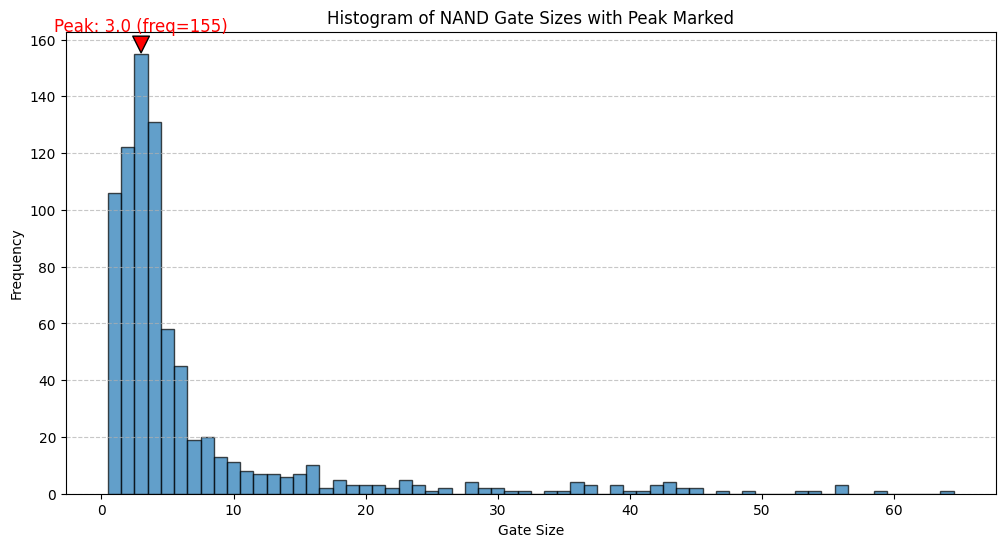

In [38]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Example: gate_types[i] corresponds to gate at x_cont[i]
# Filter for only NAND2 gate sizes (assuming the type in gate_types is lowercase 'nand')
# If you have different NAND types like NAND2, NAND3, etc., you might need a more specific check
# or extract the base type like 'nand' from the full type string.
# For this fix, we assume we are looking for gates of type 'nand'.
nand2_sizes = [size for size, gtype in zip(x_cont, gate_types) if gtype.lower() == 'nand']

# Count frequency of each gate size
freq = Counter(nand2_sizes)

# Check if freq is empty before trying to find the peak
if freq:
    # Find the size with the highest frequency
    peak_size = max(freq, key=freq.get)
    peak_freq = freq[peak_size]

    print(f"Peak NAND gate size: {peak_size} with frequency: {peak_freq}")

    # Create histogram bins for discrete sizes
    # Adjust bins based on whether sizes are floats or integers
    if nand2_sizes: # Only create bins if there are sizes
        bins = np.arange(min(nand2_sizes) - 0.5, max(nand2_sizes) + 1.5, 1)

        plt.figure(figsize=(12, 6))
        counts, bins, patches = plt.hist(nand2_sizes, bins=bins, edgecolor='black', alpha=0.7)

        # Annotate the peak
        peak_index = np.argmax(counts)
        peak_x = (bins[peak_index] + bins[peak_index + 1]) / 2
        peak_y = counts[peak_index]

        plt.annotate(
            f'Peak: {peak_x} (freq={int(peak_y)})',
            xy=(peak_x, peak_y),
            xytext=(peak_x, peak_y + max(counts)*0.05),
            arrowprops=dict(facecolor='red', shrink=0.05),
            ha='center',
            color='red',
            fontsize=12
        )

        plt.title('Histogram of NAND Gate Sizes with Peak Marked')
        plt.xlabel('Gate Size')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No NAND gates found in the netlist to plot.")

else:
    print("No NAND gates found in the netlist to determine peak size.")

In [ ]:
import json
import re

def extract_gate_number(gate_name):
    """Extract the numerical suffix from a gate name like 'NAND2_87'."""
    match = re.search(r'_(\d+)$', gate_name)
    return int(match.group(1)) if match else float('inf')

def json_to_ordered_text(json_path, txt_path):
    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Sort keys by the numeric suffix
    sorted_items = sorted(data.items(), key=lambda x: extract_gate_number(x[0]))

    # Write to the text file in the desired format
    with open(txt_path, 'w') as f:
        for gate, size in sorted_items:
            f.write(f"{gate} - {float(size):.2f}\n")

# Example usage
json_to_ordered_text('c880_cont_soln2.json', 'c880_cont_soln2.txt')
